# Predicción de ventas para BlackFriday


## Problema

Un alto directivo de la empresa X está solicitando a nuestro equipo de ingenieros desarrollar un sistema que permita predecir información relevante para el próximo Blackfriday que se llevará a cabo en noviembre 23 del 2018, tomando como base los datos de ventas del blackfriday del año pasado que se llevó a cabo en noviembre 24 2017. 

El sistema debe ser capaz de responder las siguientes preguntas de forma gráfica y tabular (en tablas):

1. Unidades que se venderán por producto.
2. Total de ventas (valor de ventas) por producto en pesos. 
3. Top de compradores. 
4. ¿Nos comprarán más las personas solteras o las personas casadas? (en el dataset asumimos casadas como 1).
5. ¿Nos comprarán más los hombres o las mujeres? 
6. Clasifique por edades, que producto que se venderá más.

Para calcular los pesos se debe predecir el valor del dólar efectuando una regresión con los datos de dataset: TRM_Historico.xls 
* Se recomienda la librería [Bokeh](https://bokeh.pydata.org/en/latest/)

## Requerimientos

- El sistema debe usar ML para resolver las preguntas.
- Django 2.1 y Python 3.7 (librerías de ML)
- Postgress, en caso de requerir el uso de una BD

## Observaciones

#### TRM
La TRM es la Tasa Representativa del Mercado cambiario de Colombia y representa el valor que tiene un dólar estadounidense en pesos colombianos. 

#### Limitantes
- Detalle del crecimiento de la población:
Esta predicción no toma en cuenta nuevos usuarios ni el crecimiento de la población de usuarios que accedio a la tienda en el último año.

Para solventar esta limitación el modelo se puede ajustar con un factor de crecimiento de población, es decir, un dato parametrizable ingresado por el usuario. Cabe aclarar, que este dato es un valor de crecimiento general y no discrimina por la demografia del usuario.

#### Versión de Django
Se actualiza la versión del _framework Django_ a la **2.1.2** debido a que en la versión **2.1** se reporto recientemente un fuerte problema de seguridad.

## Primera parte: predicción del valor del dolar

Vamos a realizar una regresión lineal con los datos de dataset: TRM_Historico.xls para predecir el valor del dolar el día 23-nov-2018, día en que se realizará el evento.

In [179]:
# importando librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [416]:
dolars = pd.read_excel('datasets/TRM_Historico.xls')

In [417]:
# explorando el dataset
dolars.head()

,Fecha,TRM
0,1991-11-27,693.32
1,1991-11-28,693.99
2,1991-11-29,694.70
3,1991-11-30,694.70
4,1991-12-01,643.42


In [418]:
# consultando los tipos de datos
dolars.dtypes

Fecha    datetime64[ns]
TRM             float64
dtype: object

In [419]:
# informacion del dataset
dolars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9821 entries, 0 to 9820
Data columns (total 2 columns):
Fecha    9821 non-null datetime64[ns]
TRM      9821 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 153.5 KB


In [420]:
dolars.describe()

,TRM
count,9821.000000
mean,1947.144108
std,705.396325
min,620.620000
25%,1397.120000
50%,1965.830000
75%,2389.750000
max,3434.890000


La exploración previa muestra que no tenemos valores nulos. Ahora vamos a modificar el indice

In [421]:
dolars.index = dolars.Fecha
dolars.index.names = ['index']

In [422]:
dolars.head()

,Fecha,TRM
index,,
1991-11-27,1991-11-27,693.32
1991-11-28,1991-11-28,693.99
1991-11-29,1991-11-29,694.70
1991-11-30,1991-11-30,694.70
1991-12-01,1991-12-01,643.42


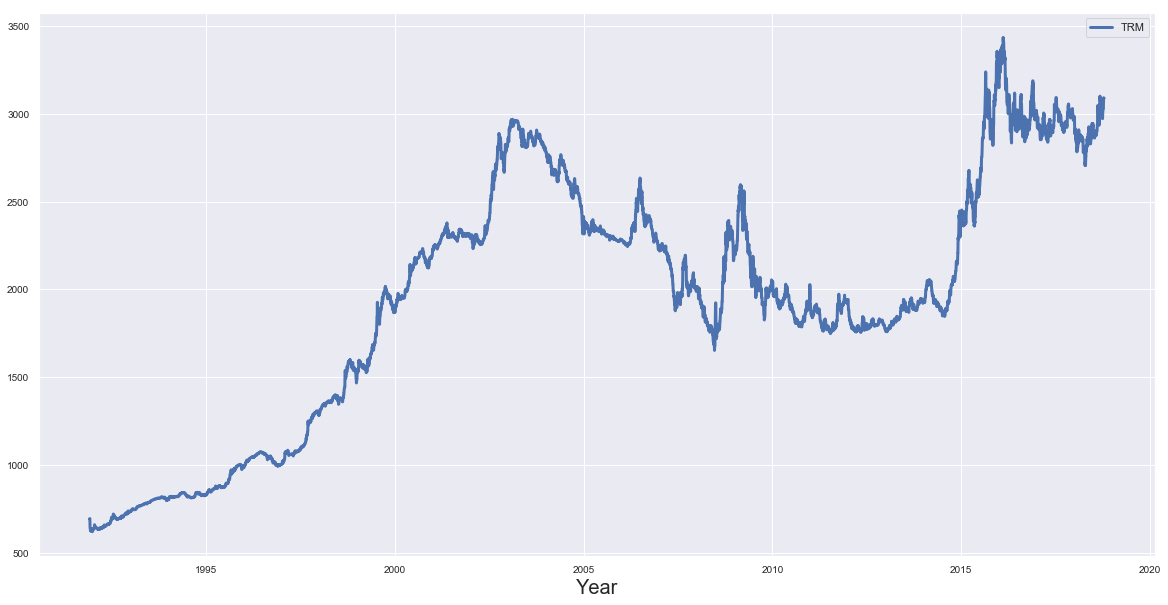

In [423]:
dolars.plot(x='Fecha', y='TRM', figsize=(20,10), linewidth=3, fontsize=10)
plt.xlabel('Year', fontsize=20);
plt.show()

In [25]:
# df_2000 = dolars.loc[pd.Timestamp('2000-01-01'):pd.Timestamp('2018-12-31')]

Un modelo de regresión lineal solo funciona sobre tipos numericos, así que vamos a transformar nuestra fecha.

In [424]:
dolars['Fecha'].dtype


dtype('<M8[ns]')

In [425]:
import datetime as dt
dolars['Fecha'] = pd.to_datetime(dolars['Fecha'])
dolars['Fecha'] = dolars['Fecha'].map(dt.datetime.toordinal)

In [426]:
dolars['Fecha'].dtype

dtype('int64')

In [427]:
dataX = dolars[["Fecha"]]

# genero el array 2d con indice y fecha
dates = np.array(dataX)

# valores del dolar en el indice X_train
prices = dolars['TRM'].values

In [429]:
dolars.tail()

,Fecha,TRM
index,,
2018-10-12,736979,3087.34
2018-10-13,736980,3088.78
2018-10-14,736981,3088.78
2018-10-15,736982,3088.78
2018-10-16,736983,3088.78


In [430]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# separar datos dataset de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(dates, prices)

In [504]:
# Creamos el objeto LinearRegression (Modelo)
regr = LinearRegression()

# Ajustamos a nuestro modelo con los datos
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [505]:
# Imprimimos el Coeficiente estimado para el problema
print('Coeficiente: \n', regr.coef_, regr.intercept_)

Coeficiente: 
 [0.18615266] -134328.46392319226


In [506]:
regr.predict(X_test)

array([1821.9177529 , 1993.17820202, 2487.41351986, ..., 2647.69096191,
       1464.13233637, 2026.87183385])

vamos a comparar con el primer dato de prueba, la Fecha: [729620] tiene una TRM de 1385.77

In [508]:
print('Fecha: ',X_test[0], 'TRM', y_test[0])
print(dolars.iloc[2457, :])
print(regr.predict([[729620]]))

Fecha:  [731391] TRM 2815.26
Fecha    729620.00
TRM        1385.77
Name: 1998-08-19 00:00:00, dtype: float64
[1492.24138834]


In [502]:
print(type(x), type(y), len(x), len(y))
print(type(x2), type(y_pred), len(x2), len(y_pred))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 95 95
<class 'numpy.ndarray'> <class 'numpy.ndarray'> 2456 2456


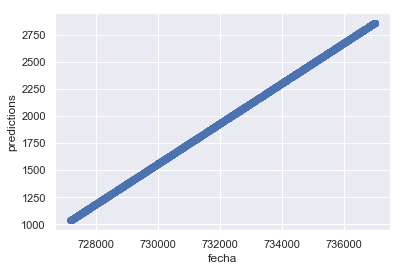

In [509]:
# Visualize the inputs and predicted values
plt.scatter(X_test, y_pred)
plt.xlabel('fecha')
plt.ylabel('predictions')
plt.show()

In [510]:
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py

# coeficiente de determinación
# mejor puntuación posible 1

from sklearn.metrics import r2_score, mean_squared_error

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [0.18615266]
Mean squared error: 223305.64
Variance score: 0.54


In [511]:
# calcular la prediccion del dolar para la fecha deseada 23-nov-2018

from datetime import datetime as dt
d = dt.strptime('2018-11-23', '%Y-%m-%d').date()
print(d)

print(d.toordinal())


2018-11-23
737021


In [513]:
trm_bf_2018 = regr.predict([[737021]])
print('El valor de la TRM esperado para el Black Friday es: ${} pesos'.format(round(trm_bf_2018[0])))

El valor de la TRM esperado para el Black Friday es: $2870.0 pesos


## otra forma

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Use stock symbols to extract training data
X = all_prices[['EBAY', 'NVDA', 'YHOO']]
y = all_prices[['AAPL']]

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, shuffle=False, random_state=1)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

In [ ]:
# Visualize our predictions along with the "true" values, and print the score
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
plt.show()